In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, solve_bvp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt

In [9]:
def generate_fishing_grounds(n_grounds = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_grounds, 2) * np.array([x_max, y_max])

In [10]:
def generate_ships(n_ships = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_ships, 2) * np.array([x_max, y_max])

In [11]:
def generate_ships_at_harbor(h, n_ships = 10):
    """
    Returns an n_ships x 2 array of ships at the harbor h
    """
    return np.array([h for _ in range(n_ships)])

In [12]:
def calculate_ship_distance_from_grounds(ships, grounds):
    return np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)

In [13]:
def d_matrix(ships, grounds):
    # Vectorized difference calculation
    differences = grounds - ships[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)
    return differences / (distances + 1e-6)  # Adding small value to avoid division by zero

In [14]:
def ship_ground_gaussians(ships, grounds, alpha):
    distances = np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)
    return np.exp(-alpha * distances**2)

In [15]:
def calculate_ship_distance_from_ships(ships):
    return np.linalg.norm(ships[:, np.newaxis] - ships, axis=2)

In [16]:
def harbor_attraction(U, ships, h):
    diff = h - ships
    diff_norm = np.linalg.norm(diff, axis=1, keepdims=True) + 1e-6
    return U[:, -2, np.newaxis] * (diff / diff_norm)

In [17]:
def attraction_matrix(U, G, D, F):
    F_reshaped = F.reshape(1, -1, 1)
    return U[:, :-2, None] * G[:, :, None] * D * F_reshaped

In [18]:
def calculate_F_prime(t, F, C, rate):
    C_sum = np.sum(C, axis=0)
    return -rate * F * C_sum

In [19]:
def calculate_S_matrix(A, H):
    return np.sum(A, axis=1).reshape(-1, 2) + H

In [20]:
def calculate_x_prime(U, S):

    # Reshape U[:,-2] to have an extra dimension
    U_reshaped = U[:,-1].reshape(-1, 1)

    return U_reshaped * S

Take orthogonal unit vector to s_i, r_i

inner product that with p_i, take abs value

find minimum of that <r_i, p_i>

Penalize ||u_i,j(t-1) - u_i,j(t)||

so minimize over u_ij for all i, j <r_i, p_i> + ||u_i,j(t-1) - u_i,j(t)||

In [69]:
# LIKELY WRONG

def Dxs_matrix(x, grounds, ships, G, U, F, distances, differences, alpha, h):
    F_reshaped = F.reshape(1, -1, 1)
    
    # This will have shape (N, K, 1)
    outer_scalar = (U[:, :-2, None] * G[:, :, None] * F_reshaped) / (distances + 1e-6)
    
    # Calculate the inner scalar term, reshaping it to (N, K, 1, 1) to broadcast with the outer product
    inner_scalar = (alpha + 1 / (distances[..., 0]**2 + 1e-6)).reshape(*distances.shape[:2], 1, 1)
    
    # Compute the outer products
    outer_products = differences[..., np.newaxis] * differences[..., np.newaxis, :]
    
    # Identity matrix needs to be (1, 1, 2, 2) to broadcast correctly
    I_2 = np.eye(2).reshape((1, 1, 2, 2))

    # print((inner_scalar * outer_products - I_2).shape)
    
    # The term_inside_summation should have shape (N, K, 2, 2)
    term_inside_summation = outer_scalar[..., np.newaxis] * (inner_scalar * outer_products - I_2)
    
    # Sum over the second axis, corresponding to summing over 'j' (the grounds)
    # This will result in shape (N, 2, 2)
    DxS = np.sum(term_inside_summation, axis=1)

    diff = h - ships
    diff_norm = np.linalg.norm(diff, axis=1, keepdims=True) + 1e-6
    
    u_ratio = U[:, -2] / diff_norm.squeeze()

    h_outer_products = diff[..., np.newaxis] * diff[..., np.newaxis, :]

    h_inner = np.sum(diff**2, axis=1)

    h_outer_products /= h_inner[:, np.newaxis, np.newaxis] + 1e-6


    I_2 = np.eye(2).reshape((1, 2, 2))
    
    return DxS + ((h_outer_products - I_2) * u_ratio[:, np.newaxis, np.newaxis])


In [73]:
def calculate_p_prime(S, U, Dxs, ship_differences, ship_distances):

    # Shape: (N, 2, 2), the outer product of S
    S_outer = S[:, :, np.newaxis] * S[:, np.newaxis, :]

    # Shape: (N, K, 2), the inner product of S with the differences
    S_inner = np.sum(S**2, axis=1)

    # Shape: (N, 2, 2)
    S_outer /= (S_inner[:, np.newaxis, np.newaxis] + 1e-6)
    # print(S_outer.shape)

    I_2 = np.eye(2).reshape((1, 2, 2))

    first_term = I_2 - S_outer
    # print(first_term.shape)

    second_term = (Dxs / np.linalg.norm(S, axis=0, keepdims=True))
    # print(second_term.shape)

    second_term *= U[:, -1, np.newaxis, np.newaxis]

    combined = first_term * second_term

    # np.fill_diagonal(ship_differences[:, :, 0], 0)
    # np.fill_diagonal(ship_differences[:, :, 1], 0)

    # Sum up, skip where i == j
    term_inside_summation = ship_differences / (np.linalg.norm(ship_differences, axis=1)**2 + 1e-6)**2

    second_term = np.sum(term_inside_summation, axis=1)
    # print(second_term)

    

In [72]:
def ode(t, y, params):
    alpha, sigma, rate, U, grounds, h, x_size, F_size, x_shape = params
    x = y[:x_size].reshape(x_shape)  # reshape x back to its original shape
    F = y[x_size:x_size+F_size]
    differences = grounds - x[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)

    ship_diffences = x[:, np.newaxis] - x
    ship_distances = np.linalg.norm(ship_diffences, axis=2)

    # Calculate D matrix
    D = differences / (distances + 1e-6)

    # Calculate G matrix
    G = ship_ground_gaussians(x, grounds, alpha)

    # Calculate Collection matrix
    C = ship_ground_gaussians(x, grounds, sigma)

    # Calculate A matrix
    A = attraction_matrix(U, G, D, F)

    # Calculate H
    H = harbor_attraction(U, x, h)


    S = np.sum(A, axis=1).reshape(-1, 2) + H

    S_normal = S / (np.linalg.norm(S, axis=1, keepdims=True) + 1e-6)

    F_prime = calculate_F_prime(t, F, C, rate)


    x_prime = calculate_x_prime(U, S_normal)

    # print(G.shape, U.shape, F.shape, distances.shape)
          
    Dxs = Dxs_matrix(x, grounds, x, G, U, F, distances, differences, alpha, h)


    p_prime = calculate_p_prime(S, U, Dxs, ship_diffences, ship_distances)


    # Flatten x_prime and F_prime and concatenate them into a single 1D array
    return np.concatenate((x_prime.flatten(), F_prime.flatten()))

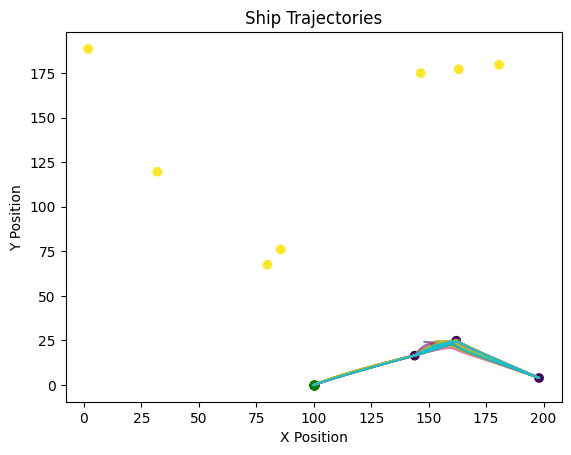

In [74]:
alpha = .001
sigma = 1
rate = .1

x_max, y_max = 200, 200

# h is the harbor position
h = np.array([x_max / 2, 0])

grounds = generate_fishing_grounds(10, x_max, y_max)
# ships = generate_ships(20)
ships = generate_ships_at_harbor(h, 20)

# initialize U as all ones
U = np.ones((ships.shape[0], grounds.shape[0] + 2))

# initialize U with normal distribution, mean 1, std 0.1
U = np.random.normal(1, .25, (ships.shape[0], grounds.shape[0] + 2))

# set the last column of U to 0
U[:,-2] = 0
U[:,-1] = 1

# initialize F as all ones
F = np.ones(grounds.shape[0])

# x is ship positions
x = ships

# Get the sizes of x and F before flattening
x_size = np.prod(x.shape)
F_size = np.prod(F.shape)

# Get the original shape of x
x_shape = x.shape

# Flatten x and F into a single 1D array
y0 = np.concatenate((x.flatten(), F))

params = (alpha, sigma, rate, U, grounds, h, x_size, F_size, x_shape)

sol = solve_ivp(ode, [0, 200], y0, args=(params,), t_eval=np.linspace(0, 200, 200))

final_F = sol.y[:,-1][x_size:x_size+F_size]


# Extract ship positions from the solution
ship_positions = sol.y[:x_size].reshape(x_shape + (-1,))

F_normalized = (final_F / np.max(F)) * 100  # Example normalization to 100

plt.scatter(grounds[:, 0], grounds[:, 1], c=F_normalized, cmap='viridis', label='Fishing grounds')

# Plot the starting points of the ships
plt.scatter(ship_positions[:, 0, 0], ship_positions[:, 1, 0], c='green', label='Starting points')

# Plot the trajectory of each ship
for i in range(ship_positions.shape[0]):
    plt.plot(ship_positions[i, 0, :], ship_positions[i, 1, :], label=f'Ship {i+1}')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Ship Trajectories')
plt.show()

In [524]:
# Assuming ship_positions contains the trajectory data for each ship
# and grounds contains the positions of fishing grounds

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Ship Trajectories (Animation)')

# Plot the fishing grounds and harbor for reference
ax.scatter(grounds[:, 0], grounds[:, 1], c='red', label='Fishing Grounds')
ax.scatter(h[0], h[1], marker='*', color='blue', s=200, label='Harbor')

# Initialize lines for each ship, storing them in a list
lines = [ax.plot([], [], marker='o', linestyle='-', color='green', linewidth=0.5)[0] for _ in range(ships.shape[0])]

def init():
    # Initialize lines
    for line in lines:
        line.set_data([], [])
    return lines

def animate(frame):
    # Update each ship's position for the current frame
    for i, line in enumerate(lines):
        line.set_data(ship_positions[i, 0, frame], ship_positions[i, 1, frame])
    return lines

# Create the animation
ani = FuncAnimation(fig, animate, frames=ship_positions.shape[2], init_func=init, blit=True, interval=20)

plt.legend()
plt.close(fig)  # Prevents the static plot from showing

# Display the animation
# HTML(ani.to_jshtml())
